In [3]:
# !pip install tensorflow==2.10.0

In [4]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [5]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.metrics import confusion_matrix

In [6]:
# Set directories
train_dir = '/content/drive/MyDrive/Fire-Dataset/Train'
validation_dir = '/content/drive/MyDrive/Fire-Dataset/Validation'

In [7]:
# Set hyperparameters
img_width, img_height = 224, 224
batch_size = 126
epochs = 50
initial_learning_rate = 1e-4

In [8]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 4019 images belonging to 2 classes.
Found 490 images belonging to 2 classes.


In [10]:
# Define model architecture
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

94668760/94668760 [==============================] - 2s 0us/step


In [11]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [12]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compile model
model.compile(
    optimizer=RMSprop(learning_rate=initial_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Models/FIRE_Model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [15]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
32/32 [==============================] - 153s 4s/step - loss: 0.7972 - accuracy: 0.5715 - val_loss: 0.6104 - val_accuracy: 0.6429
Epoch 2/50
32/32 [==============================] - 110s 3s/step - loss: 0.6816 - accuracy: 0.6305 - val_loss: 0.5058 - val_accuracy: 0.7347
Epoch 3/50
32/32 [==============================] - 110s 3s/step - loss: 0.5998 - accuracy: 0.6905 - val_loss: 0.4331 - val_accuracy: 0.7980
Epoch 4/50
32/32 [==============================] - 110s 3s/step - loss: 0.5376 - accuracy: 0.7350 - val_loss: 0.3744 - val_accuracy: 0.8306
Epoch 5/50
32/32 [==============================] - 109s 3s/step - loss: 0.4705 - accuracy: 0.7698 - val_loss: 0.3305 - val_accuracy: 0.8714
Epoch 6/50
32/32 [==============================] - 109s 3s/step - loss: 0.4445 - accuracy: 0.7897 - val_loss: 0.2937 - val_accuracy: 0.8959
Epoch 7/50
32/32 [==============================] - 108s 3s/step - loss: 0.3965 - accuracy: 0.8248 - val_loss: 0.2680 - val_accuracy: 0.9082
Epoch 8/50
32

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

4/4 [==============================] - 7s 2s/step - loss: 0.0899 - accuracy: 0.9735
Validation loss: 0.08987372368574142
Validation accuracy: 0.9734693765640259


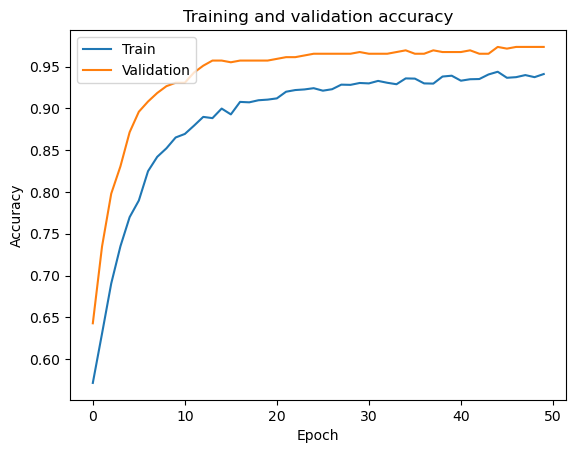

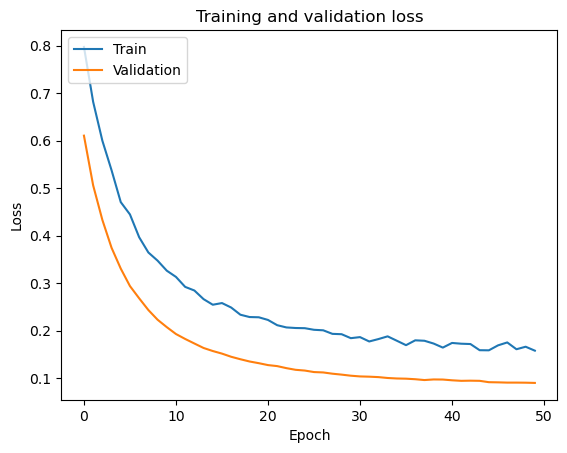

<Figure size 640x480 with 0 Axes>

In [17]:
# Get the training and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Load the best saved model
model = load_model('/content/drive/MyDrive/Models/FIRE_Model.h5')

4/4 [==============================] - 7s 2s/step


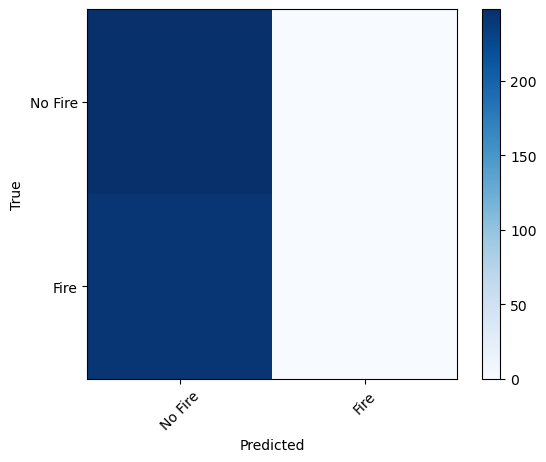

In [19]:
# Get the predicted labels for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = validation_generator.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(conf_mat, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Fire', 'Fire'], rotation=45)
plt.yticks(tick_marks, ['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()